# 房价预测

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from lazypredict import Supervised
from lazypredict.Supervised import LazyRegressor
import pandas as pd
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split

### 读入数据

In [2]:
train_path=r'E:\Program\Python\Kaggle\house_price\dataset\train.csv'
test_path=r'E:\Program\Python\Kaggle\house_price\dataset\test.csv'

In [3]:
# 训练数据
data=pd.read_csv(train_path)
# 提交结果的数据
test_data=pd.read_csv(test_path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# 数值化的列名
columns_numerical={i:data[i].dtype for i in data.columns if data[i].dtype!=object}
columns_object={i:data[i].dtype for i in data.columns if data[i].dtype==object}

有意义的列

In [6]:
columns_meaningful={'OverallQual','YearBuilt','TotalBsmtSF','GrLivArea','SalePrice'}
for j in columns_meaningful:
    print(j in columns_numerical)

True
True
True
True
True


In [7]:
data['SalePrice'].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

销售价格的分布情况，明显不是高斯分布，有点像卡方分布，存在尖峰和倾斜度

## 可视化  
首先查看所有数值型变量与房价之间的关系，先以散点图的形式呈现

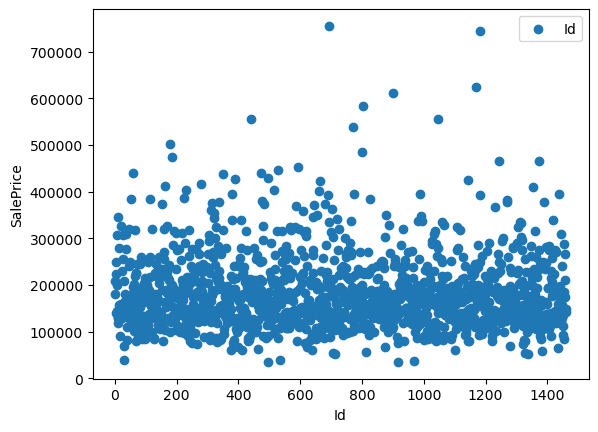

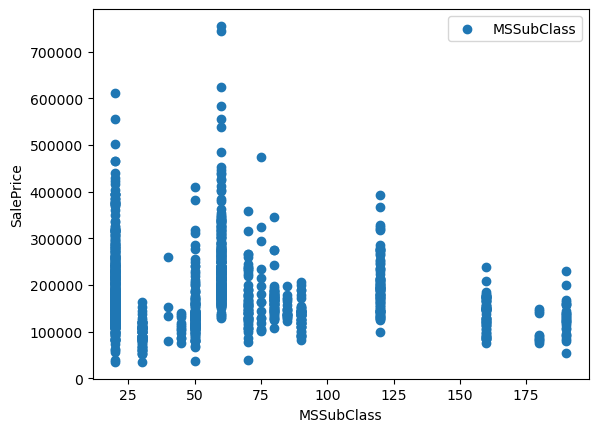

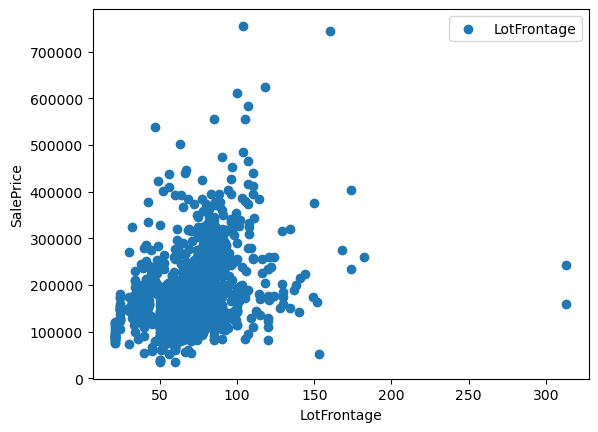

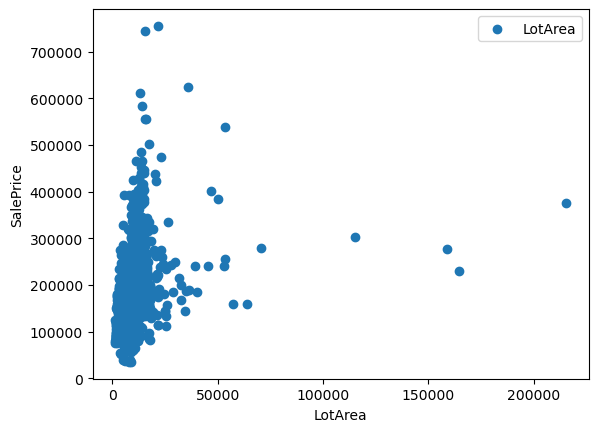

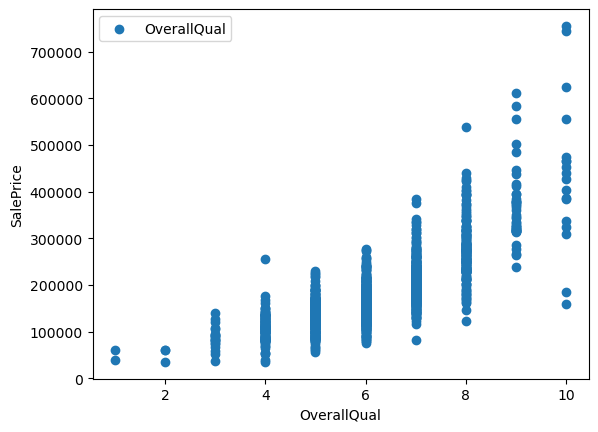

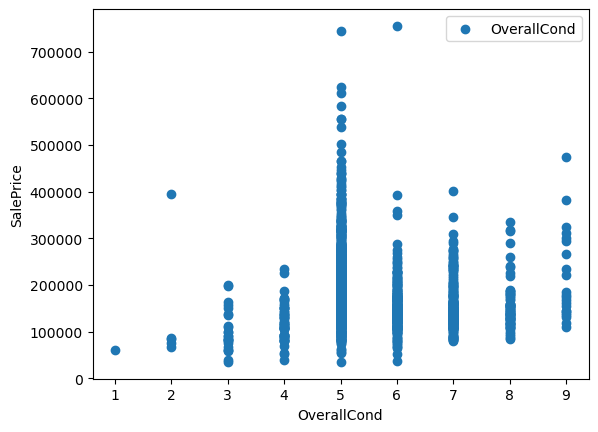

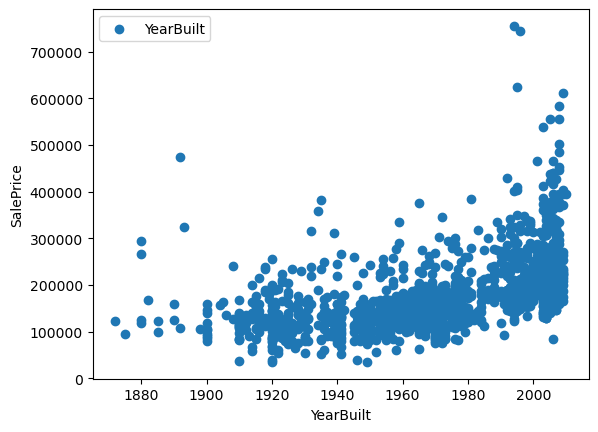

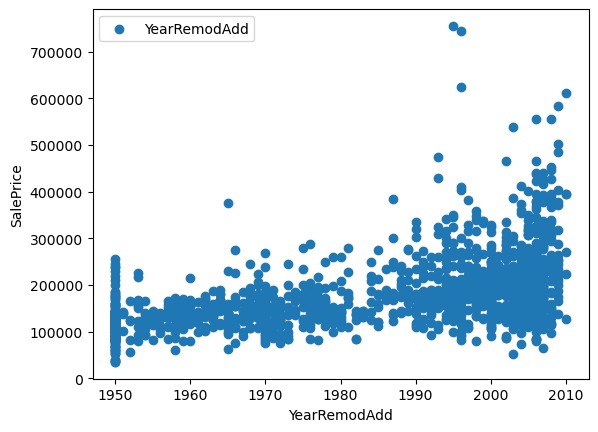

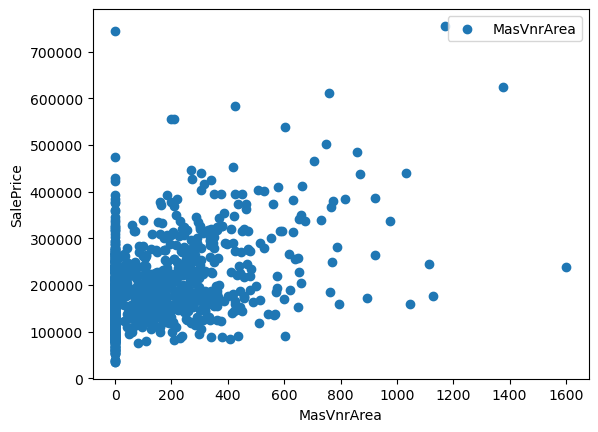

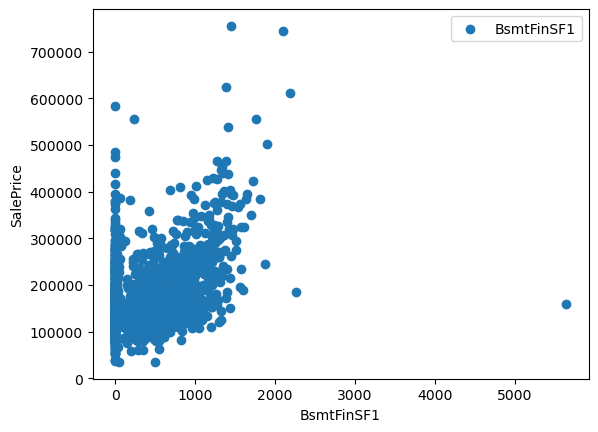

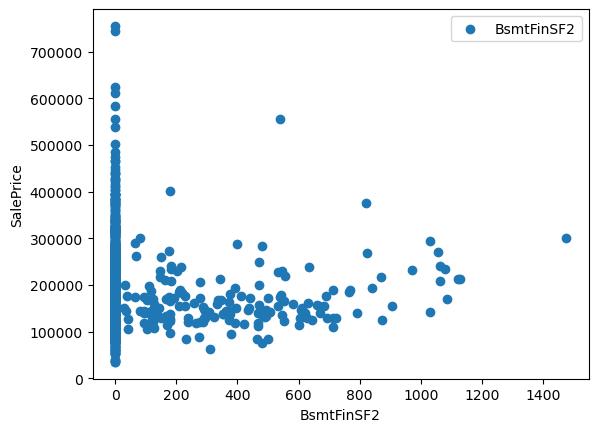

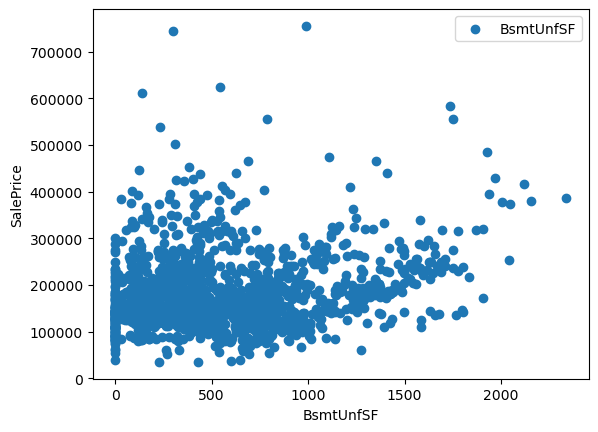

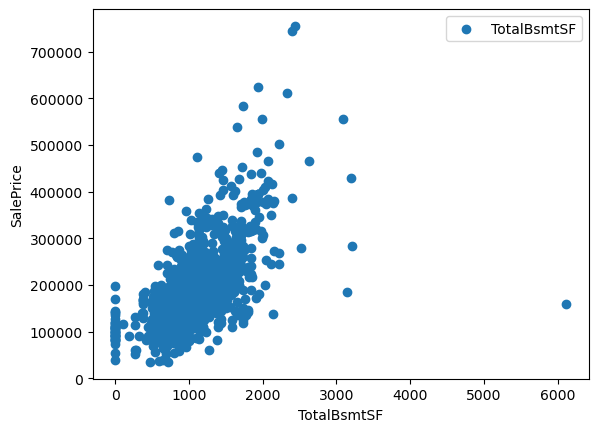

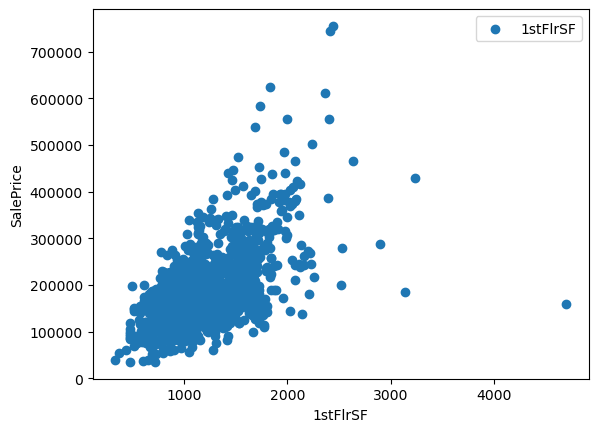

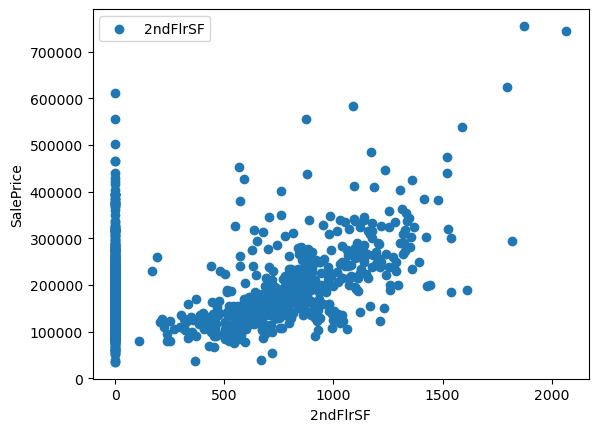

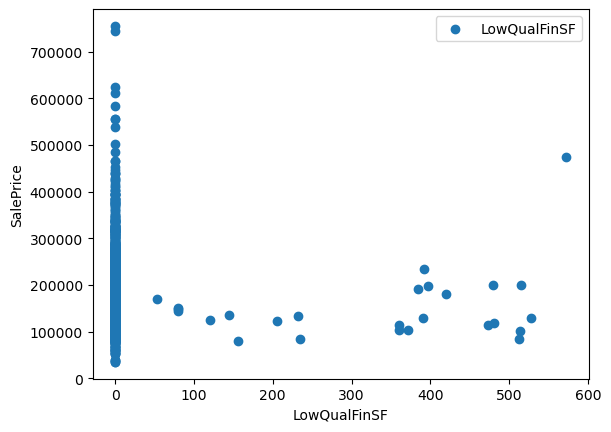

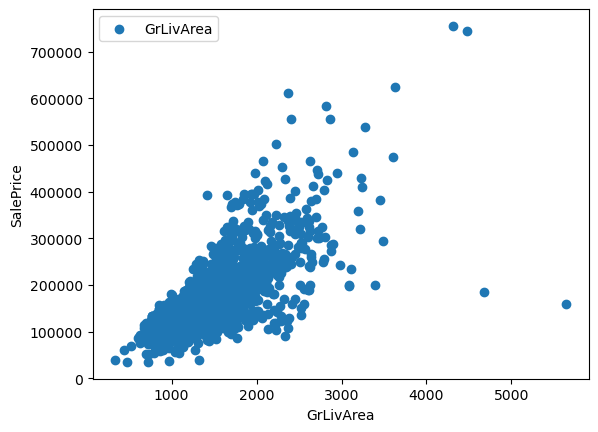

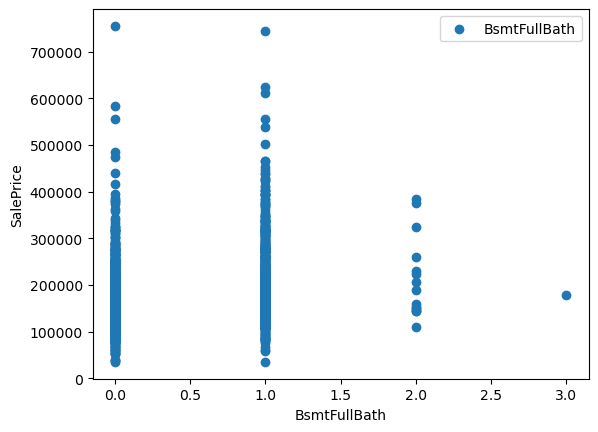

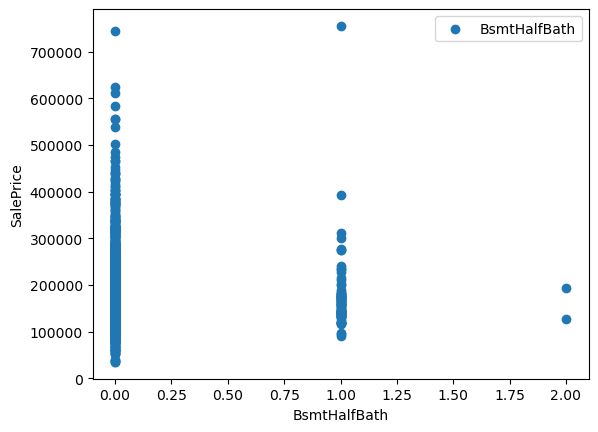

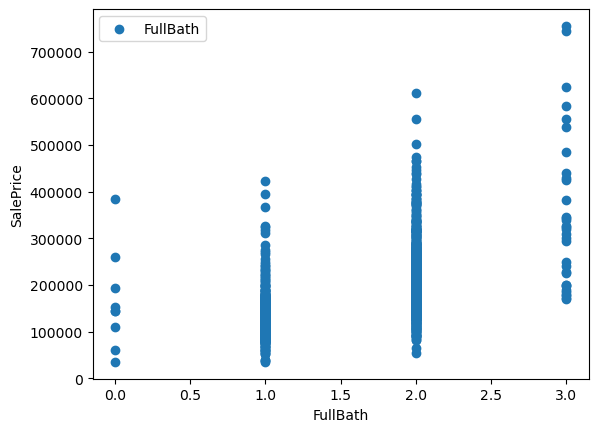

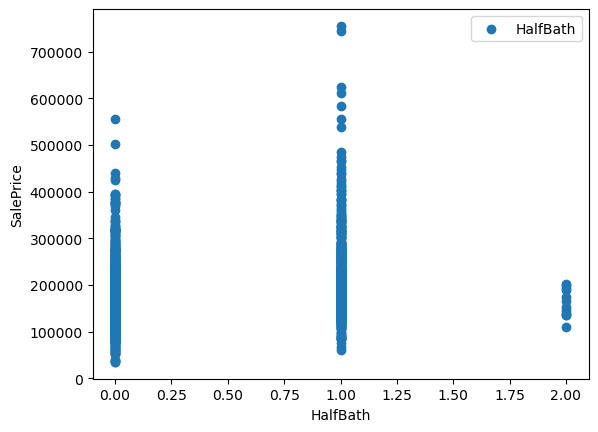

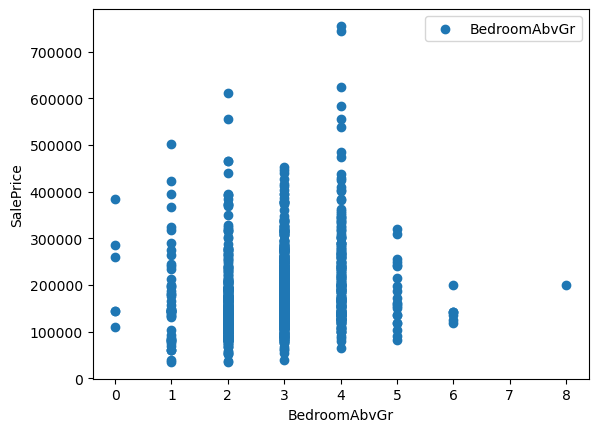

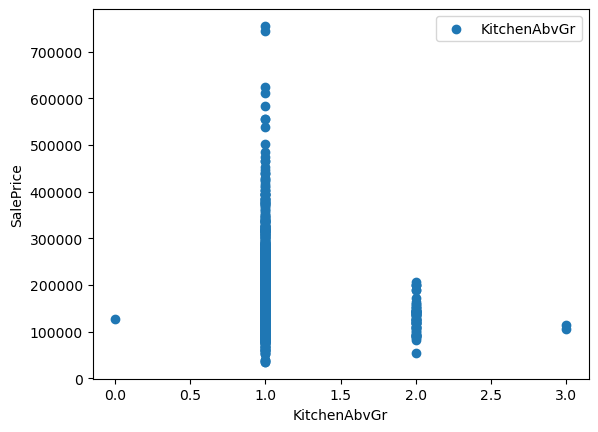

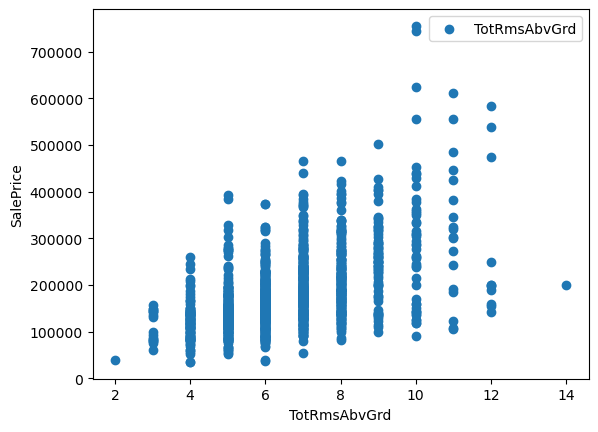

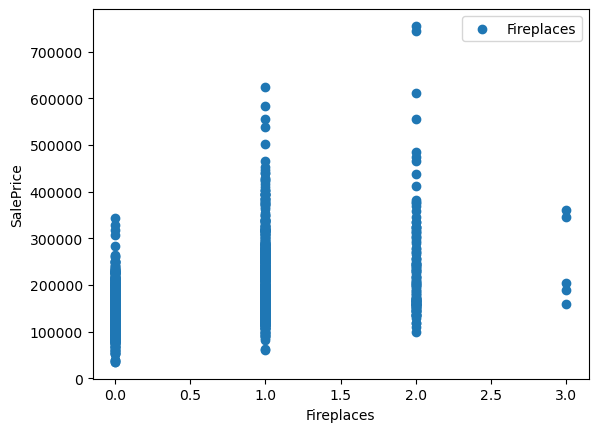

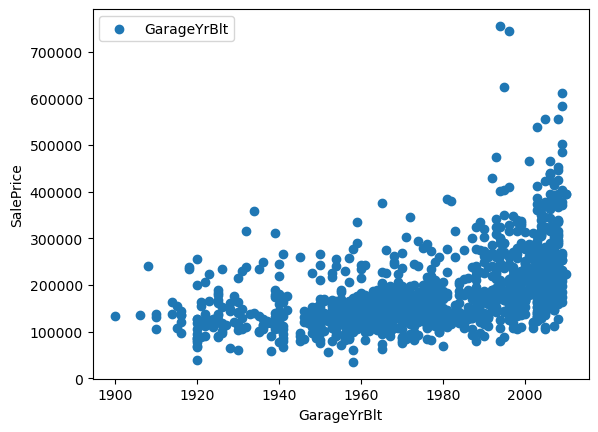

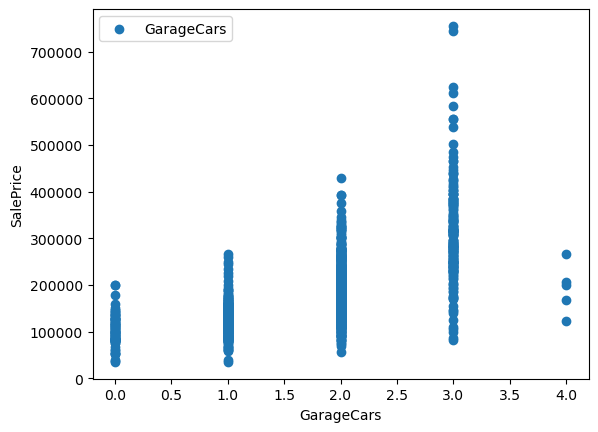

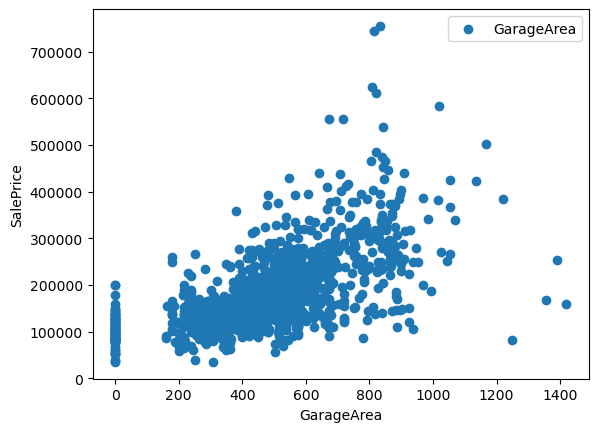

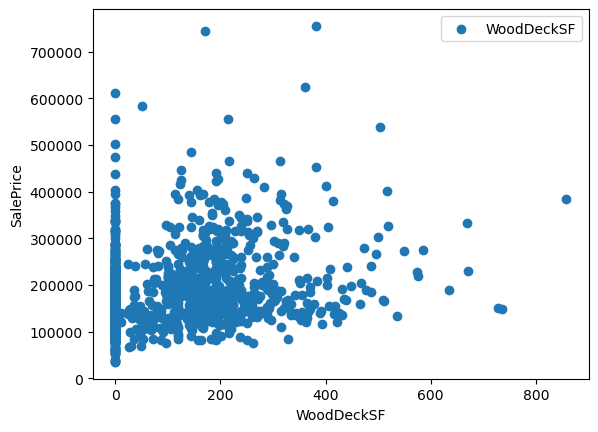

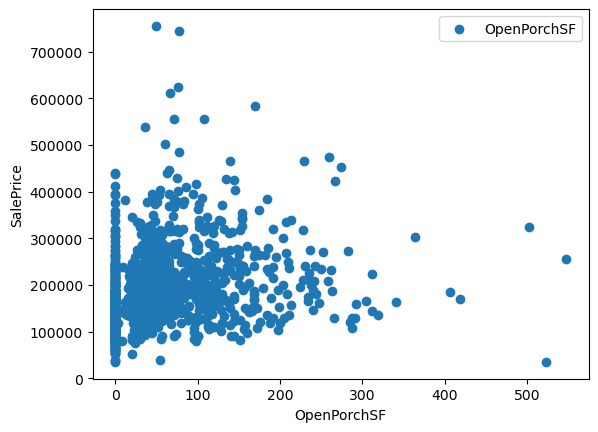

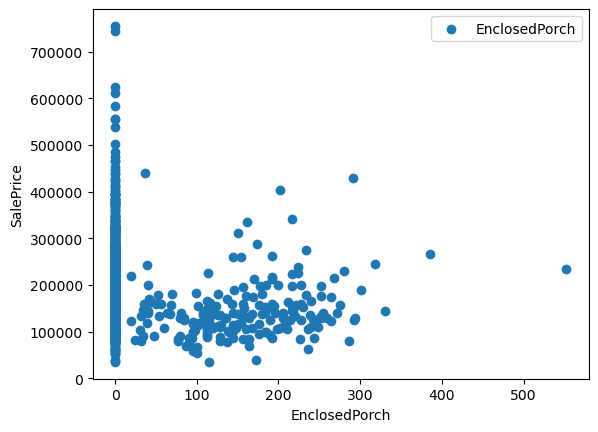

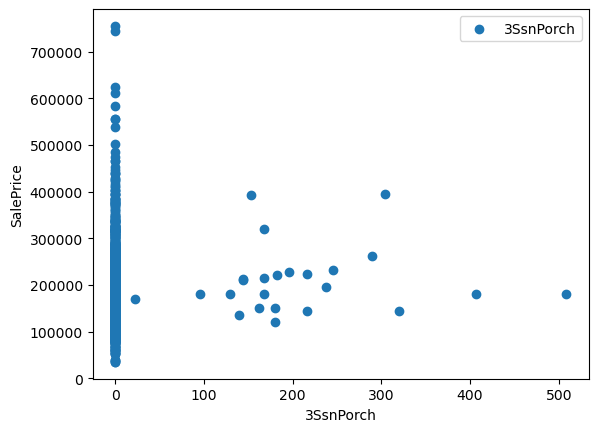

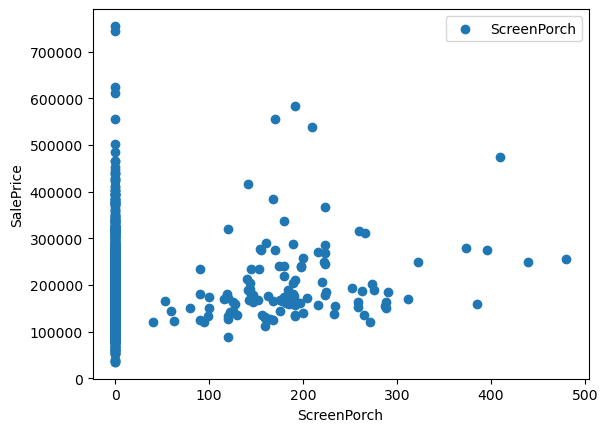

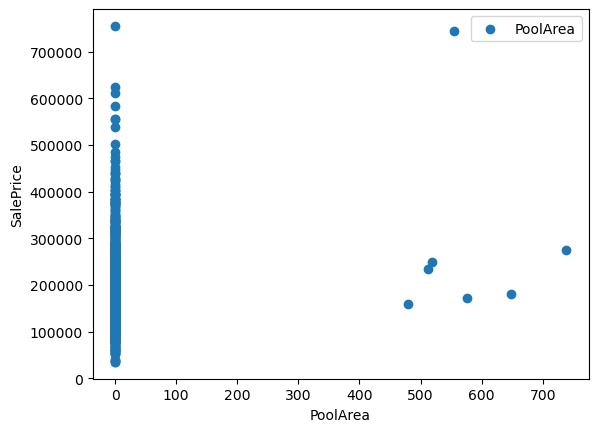

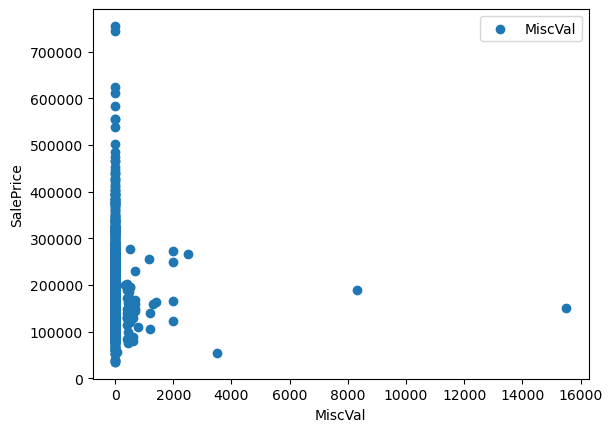

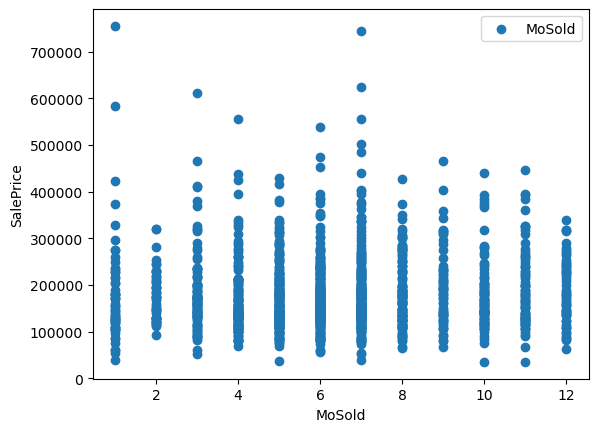

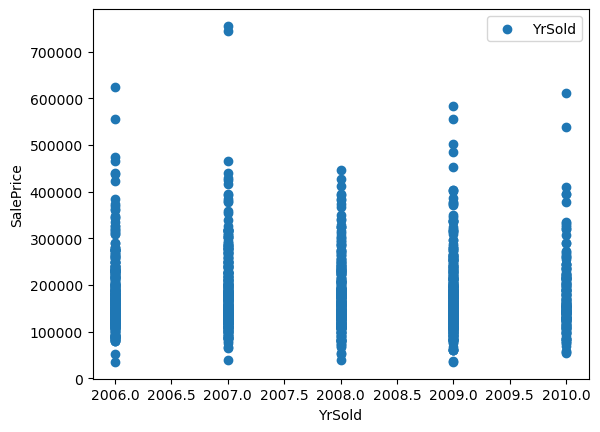

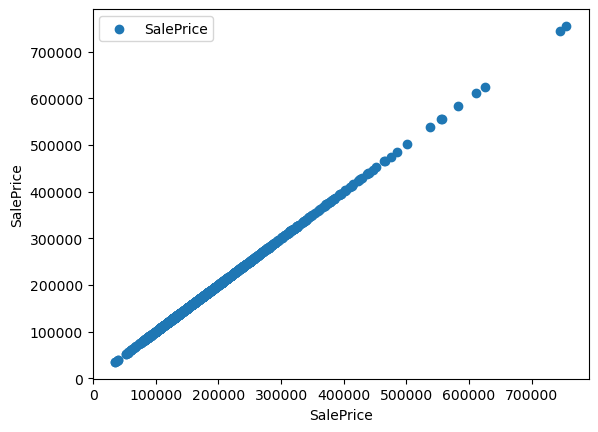

In [8]:
for j in columns_numerical:
    plt.scatter(data[j],data['SalePrice'],label=j)
    plt.xlabel(j)
    plt.ylabel('SalePrice')
    plt.legend()
    plt.show()

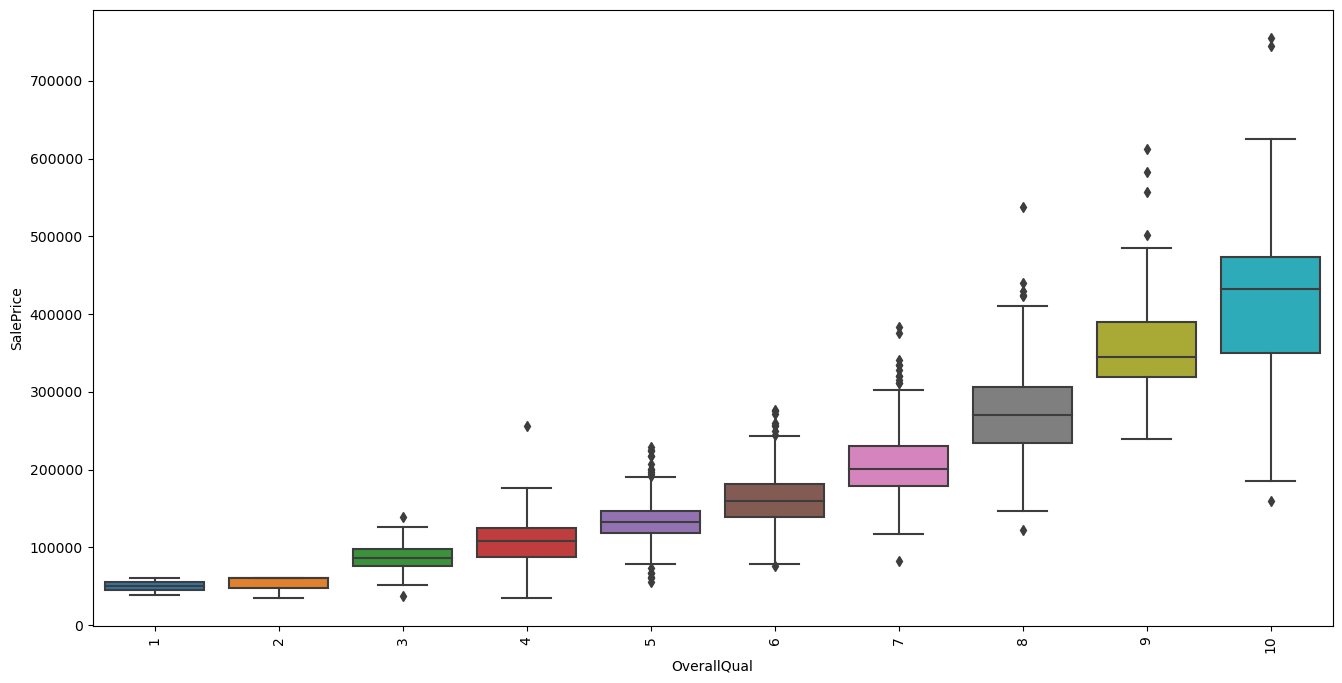

In [9]:
var='OverallQual'
data_box=pd.concat([data[var],data['SalePrice']],axis=1)
plt.figure(figsize=(16, 8))
sns.boxplot(x=var,y='SalePrice',data=data_box)
plt.xlabel(var)
plt.ylabel('SalePrice')
plt.xticks(rotation=90)
plt.show()

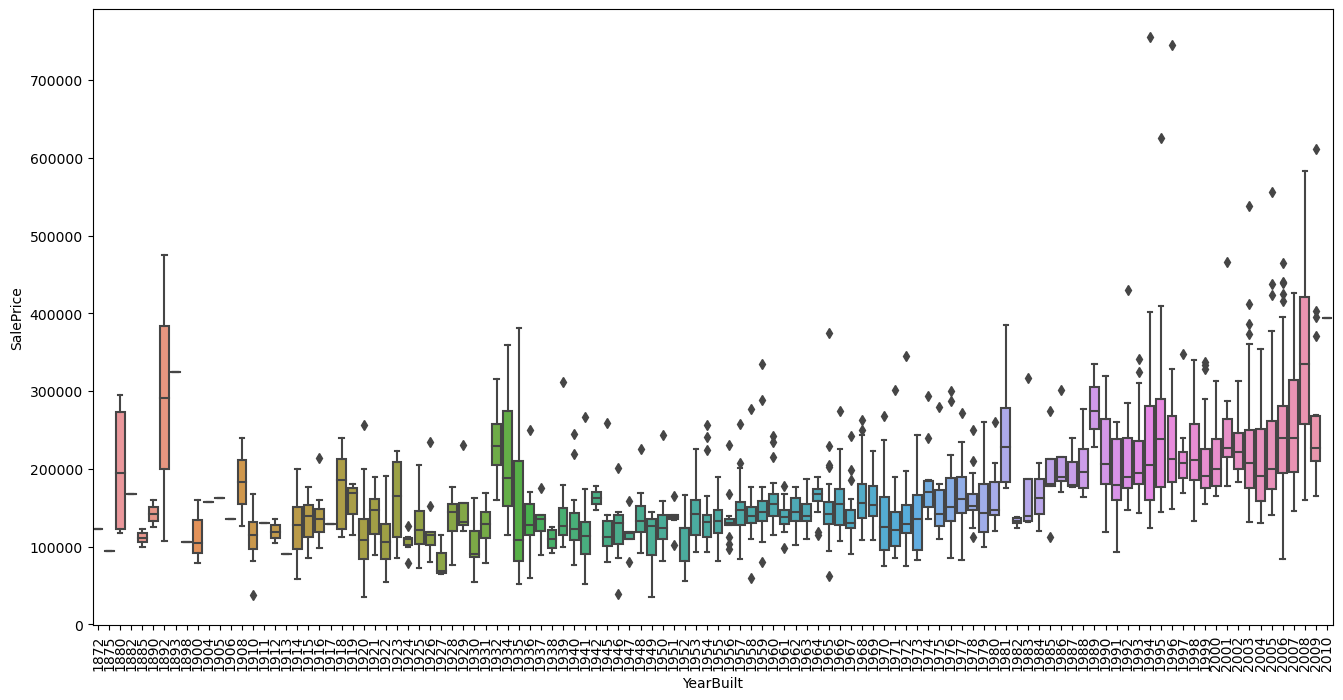

In [10]:
var='YearBuilt'
data_box=pd.concat([data[var],data['SalePrice']],axis=1)
plt.figure(figsize=(16, 8))
sns.boxplot(x=var,y='SalePrice',data=data_box)
plt.xlabel(var)
plt.ylabel('SalePrice')
plt.xticks(rotation=90)
plt.show()

## 热图，用于表现特征的相关性

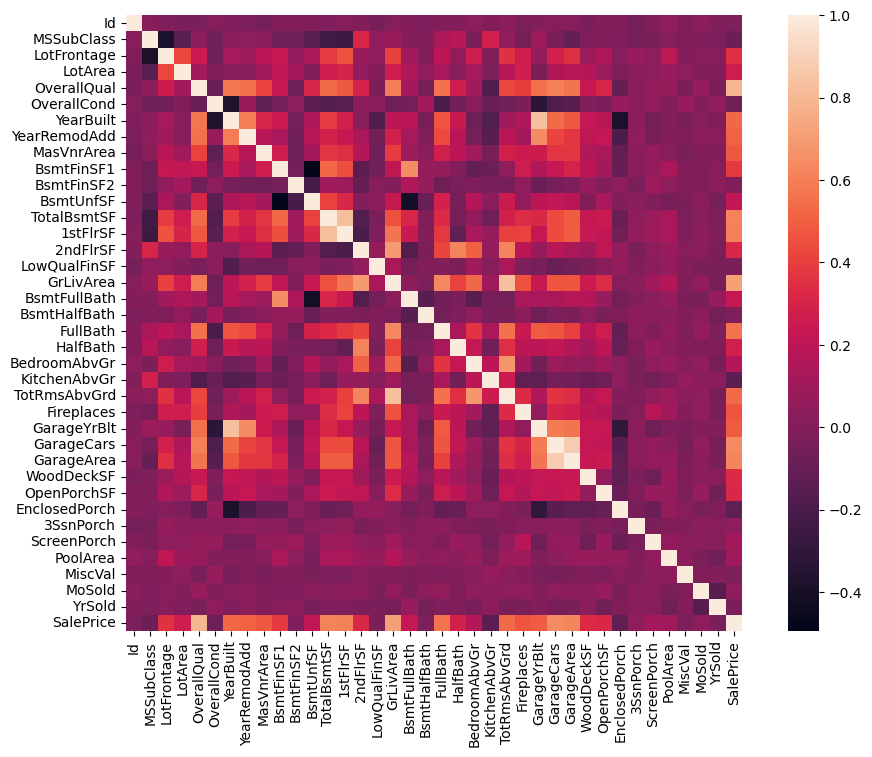

In [11]:
corr=data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr,square=True,annot=False)
plt.show()

### 选择最相关的十个特征

In [12]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
corr_10=corr.loc[cols,cols]

In [13]:
corr_10.index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

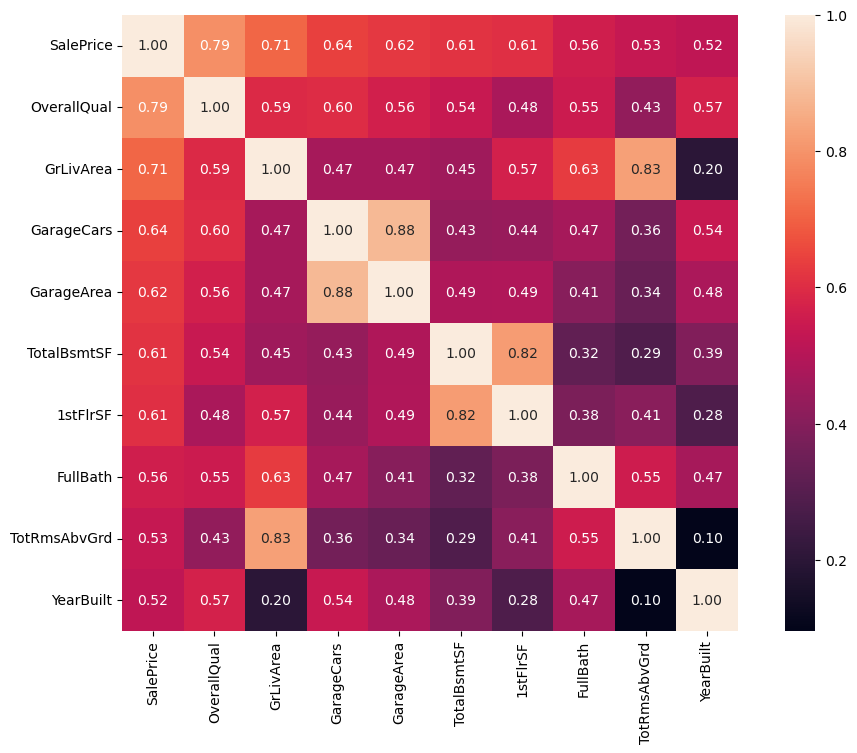

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values)
plt.show()

分析可知，销售价格与overallqual、grlivarea、garagecars和totalbsmtsf、fullbath有着较高的相关性

<Figure size 1200x800 with 0 Axes>

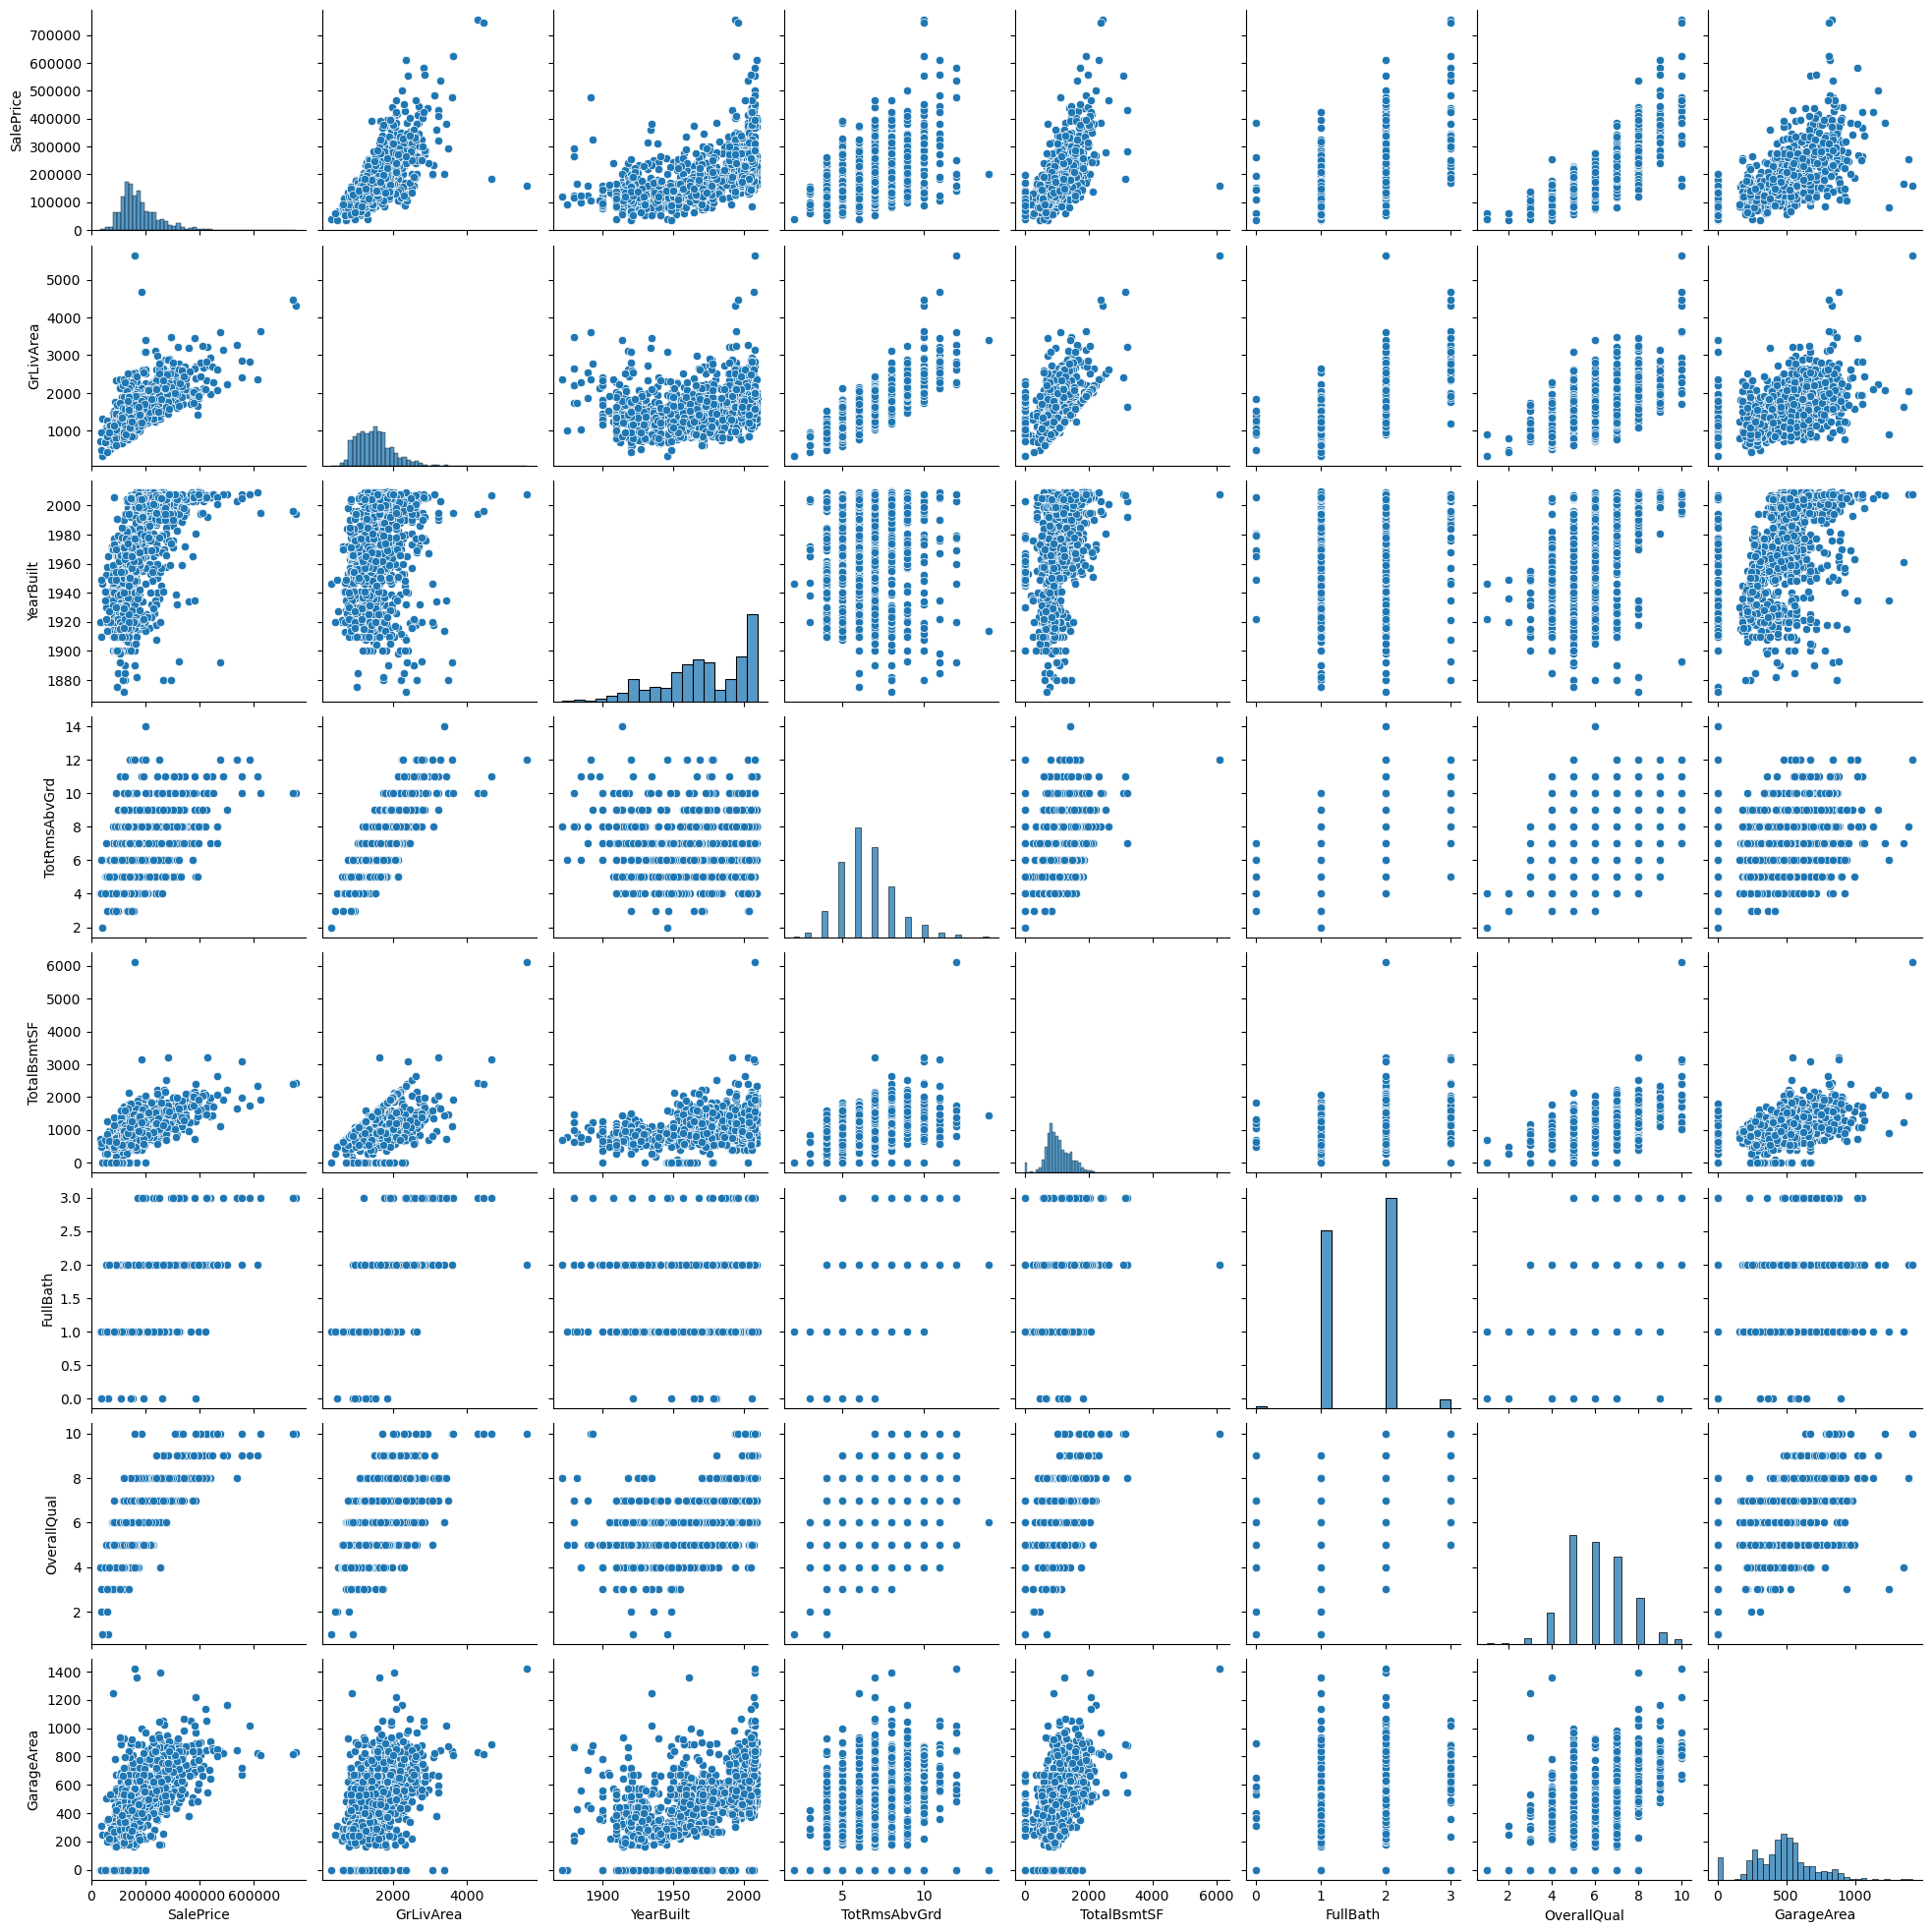

In [16]:
main_factor=set(cols)-{'1stFlrSF','GarageCars'}
data_copy=data[main_factor]
plt.figure(figsize=(12,8))
sns.pairplot(data_copy, size = 2.5)
plt.show()

## 缺失值

In [17]:
total=data.isnull().sum().sort_values(ascending=False)
percentage=data.isnull().sum().sort_values(ascending=False)/data.isnull().count()
percentage.sort_values(ascending=False,inplace=True)
null=pd.concat([total,percentage],axis=1,keys=['total','percentage'])

In [18]:
null.head(20)

,total,percentage
PoolQC,1453,1.00
MiscFeature,1406,0.96
Alley,1369,0.94
Fence,1179,0.81
FireplaceQu,690,0.47
LotFrontage,259,0.18
GarageYrBlt,81,0.06
GarageCond,81,0.06
GarageType,81,0.06
GarageFinish,81,0.06


In [19]:
# 剔除缺失值
data.drop(null[null['total']>1].index,axis=1,inplace=True)
data.drop(data[data['Electrical'].isnull()].index,inplace=True)
data.isnull().sum().sum()

0

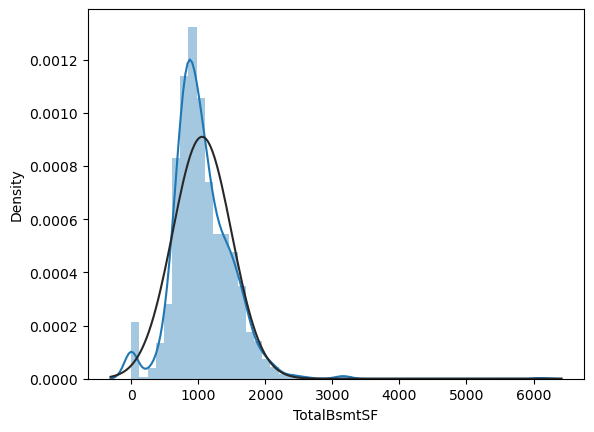

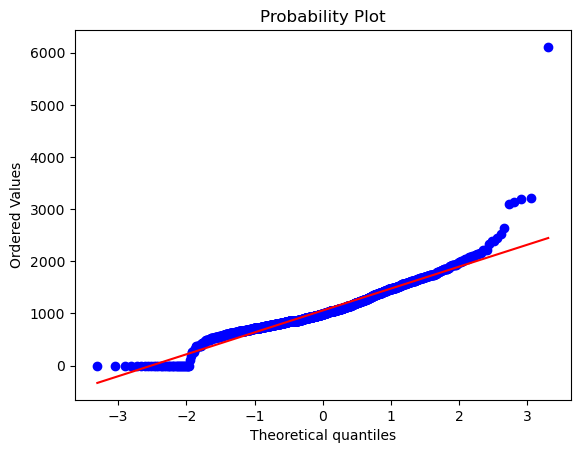

In [20]:
sns.distplot(data['TotalBsmtSF'],fit=norm)
plt.figure()
res = stats.probplot(data_copy['TotalBsmtSF'], plot=plt)
plt.show()

## 离群点  
看看价格的离群点

In [21]:
a=np.random.randn(1,100)

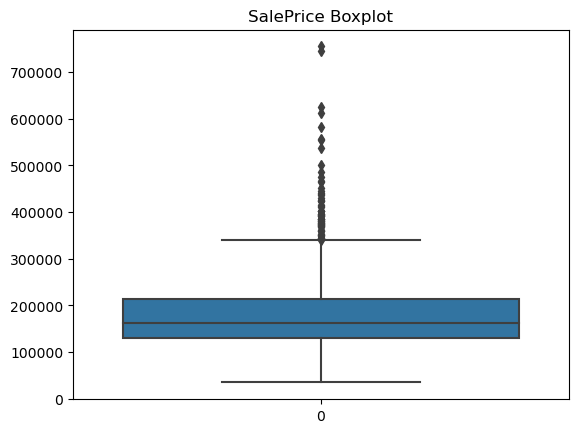

In [22]:
sns.boxplot(data['SalePrice'])
plt.title('SalePrice Boxplot')
plt.show()

In [23]:
standard_toll=StandardScaler()
price_scaled=standard_toll.fit_transform(data['SalePrice'][:,np.newaxis])
# 较小的值和较大的值
print(price_scaled[np.argsort(data['SalePrice'])][:10,]) #升序排列
print(price_scaled[np.argsort(data['SalePrice'])][-10:,]) #升序排列

[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


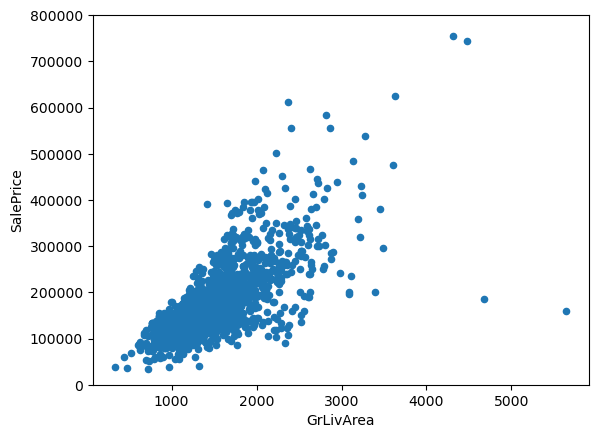

In [24]:
data[['SalePrice','GrLivArea']].plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))
plt.show()

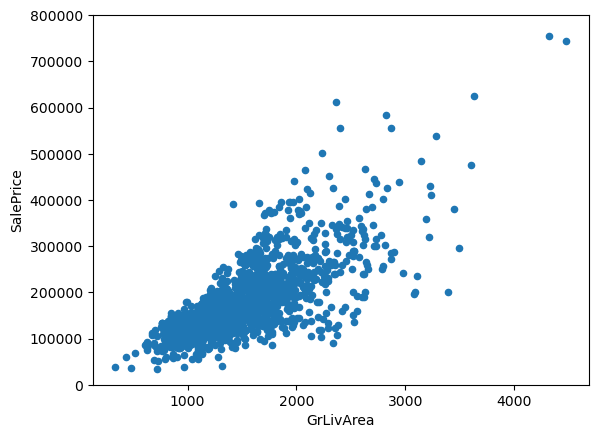

In [25]:
# 去除掉不合理的'GrLivArea'
data.drop(data['GrLivArea'].sort_values(ascending=False)[:2].index,inplace=True)
data[['SalePrice','GrLivArea']].plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0,800000))
plt.show()

## 统计学分析

In [26]:
data_copy=data.copy(deep=True)
data_copy[main_factor].describe()

,SalePrice,GrLivArea,YearBuilt,TotRmsAbvGrd,TotalBsmtSF,FullBath,OverallQual,GarageArea
count,1457.00,1457.00,1457.00,1457.00,1457.00,1457.00,1457.00,1457.00
mean,180942.14,1510.55,1971.19,6.51,1053.00,1.56,6.09,472.10
std,79521.57,508.04,30.19,1.62,414.75,0.55,1.38,212.30
min,34900.00,334.00,1872.00,2.00,0.00,0.00,1.00,0.00
25%,129900.00,1128.00,1954.00,5.00,796.00,1.00,5.00,330.00
50%,163000.00,1464.00,1972.00,6.00,991.00,2.00,6.00,480.00
75%,214000.00,1776.00,2000.00,7.00,1297.00,2.00,7.00,576.00
max,755000.00,4476.00,2010.00,14.00,3206.00,3.00,10.00,1390.00


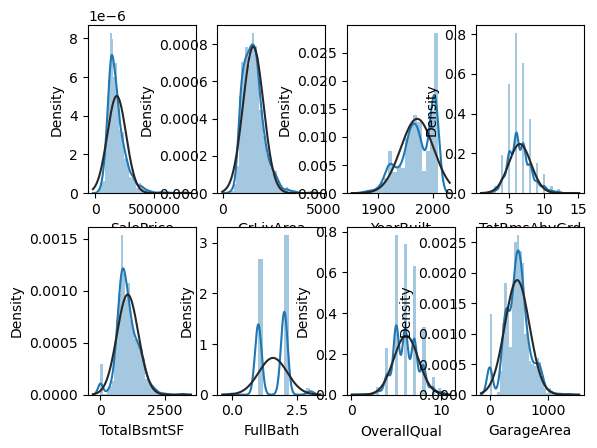

<Figure size 1200x400 with 0 Axes>

In [27]:
for index,column in enumerate(main_factor):
    ax=plt.subplot(2,4,index+1)
    # 以正态分布作基准
    sns.distplot(data[column], fit=norm)
plt.figure(figsize=(12,4))
plt.show()
    # qq图
#     res = stats.probplot(data[column], plot=plt)

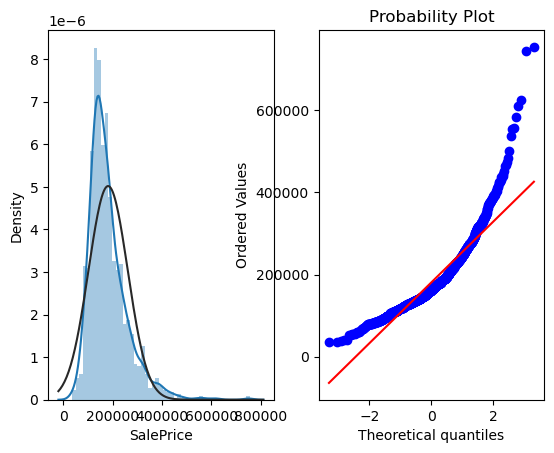

Skewness: 1.880363
Kurtosis: 6.516048


In [28]:
plt.subplot(121)
sns.distplot(data['SalePrice'], fit=norm);
# qq图
# 有点像卡方分布
plt.subplot(122)
res = stats.probplot(data['SalePrice'], plot=plt)
plt.show()
print("Skewness: %f" % data['SalePrice'].skew())
print("Kurtosis: %f" % data['SalePrice'].kurt())

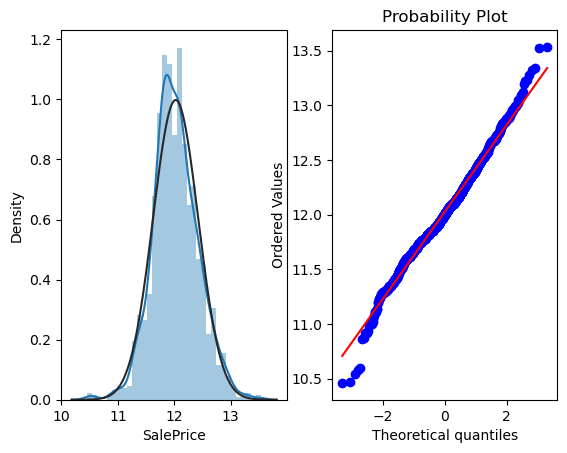

In [29]:
# 对数转换对于正偏态很有作用
data_copy['SalePrice'] = np.log(data['SalePrice'])
# 再次作图
plt.subplot(121)
sns.distplot(data_copy['SalePrice'], fit=norm);
# qq图
plt.subplot(122)
res = stats.probplot(data_copy['SalePrice'], plot=plt)
plt.show()

TotalBsmtSF存在零值，没有办法取log  
创建新列，将零值标记为0，非零值标记为1，之后对非零值取log，大佬的代码貌似可行  
或者说将地下车库面积为0的标记为1？这种方法不可行


In [30]:
# 该列没有办法进行log取值
data[data['TotalBsmtSF']>0]['TotalBsmtSF'].sort_values()
data[data['TotalBsmtSF']==0]['TotalBsmtSF'].count()

37

In [31]:
# data['BiTotalBsmtSF']=pd.Series(data['TotalBsmtSF']+1,index=data.index)

In [32]:
# sns.distplot(data_copy['BiTotalBsmtSF'],fit=norm)
# plt.figure()
# res = stats.probplot(data_copy['BiTotalBsmtSF'], plot=plt)
# plt.show()

## 开始划分数据集
数据集预处理，标准化

In [134]:
train_data=data_copy[main_factor]
# 数据集标准化
sc_x=StandardScaler()
sc_y=StandardScaler()
X=train_data[main_factor-set({'SalePrice'})]
y=train_data['SalePrice']
X,y=sc_x.fit_transform(X),sc_y.fit_transform(y.values.reshape((-1,1)))

# 20%作为测试集
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.2)

In [135]:
reg=LazyRegressor()
model,predictions=reg.fit(train_x,test_x,train_y,test_y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:13<00:00,  3.21it/s]


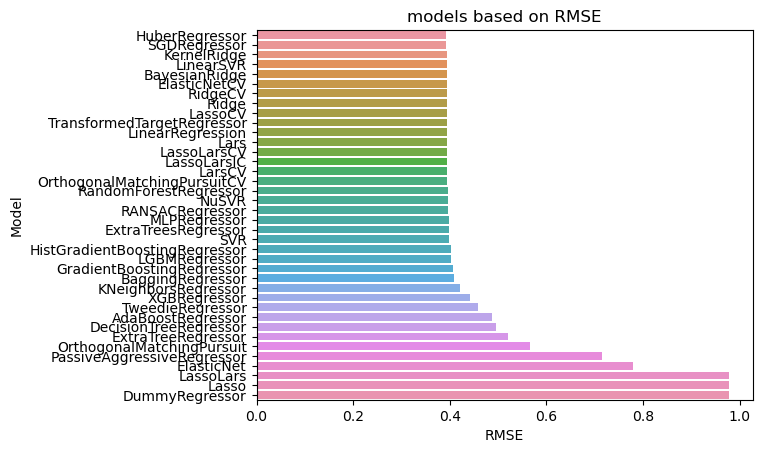

In [136]:
temp_df = model.sort_values('RMSE', ascending = True)[:-2]
sns.barplot(x = temp_df['RMSE'], y = temp_df.index).set_title('models based on RMSE')
plt.show()

## 选择得分最高的回归器进行回归

In [145]:
from sklearn.neural_network import MLPRegressor
reg=MLPRegressor()
reg.fit(X,y)

MLPRegressor()

## LinearRegression

In [112]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg_name='LinearRegression'
reg.fit(X,y)
predict_y=reg.predict(X)
mse={}
mse[reg_name]=np.sqrt(np.mean((predict_y-y)**2))

## SGDRegressor

In [94]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
reg=SGDRegressor(alpha=0.0007)
reg_name='SGDRegressor'
reg.fit(X,y)
predict_y=reg.predict(X)
mse[reg_name]=np.sqrt(np.mean((predict_y-y)**2))

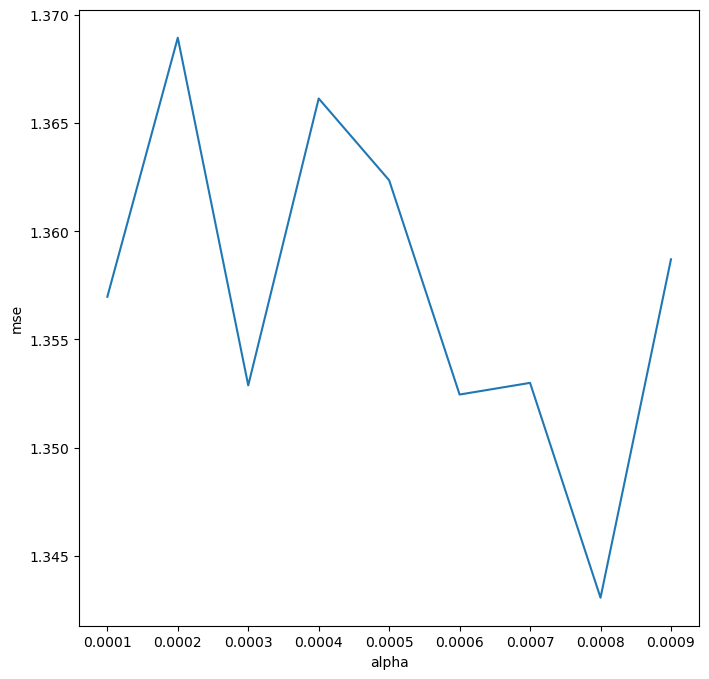

In [101]:
alpha_range=np.arange(0.0001,0.001,0.0001)
mses=[]
for alpha in alpha_range:
    reg=SGDRegressor(alpha=alpha)
    reg.fit(X,y)
    predict_y=reg.predict(X)
    mses.append(np.sqrt(np.mean((predict_y-y)**2)))
    
plt.figure(figsize=(8,8))
plt.plot(alpha_range,mses)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

## SVR

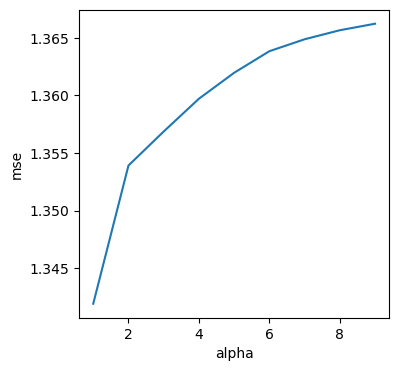

In [152]:
from sklearn.svm import SVR
reg=SVR()
C_range=np.arange(1,10,1)
mses=[]
for c in C_range:
    reg=SVR(C=c)
    reg.fit(X,y)
    predict_y=reg.predict(X)
    mses.append(np.sqrt(np.mean((predict_y-y)**2)))
    
plt.figure(figsize=(4,4))
plt.plot(C_range,mses)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

## 选择均方误差作为评价指标

In [54]:
mse=np.sqrt(np.mean((predict_y-y)**2))
mse

## 预测

In [146]:
test=test_data[main_factor-{'SalePrice'}]
print(f"缺失值的数量{test.isnull().sum().sum()}")

缺失值的数量2


In [147]:
# 去除缺失值
test.fillna(0,inplace=True)
print(f"缺失值的数量{test.isnull().sum().sum()}")
sc_x.fit_transform(test)
# 预测
test=sc_x.fit_transform(test)
outcome=reg.predict(test)

缺失值的数量0


In [148]:
# 变回原始形式
std=np.sqrt(sc_y.var_)
mean=sc_y.mean_
# 原始形式
outcome=outcome*std+mean
outcome=np.exp(outcome)
outcome = pd.DataFrame({'Id': test_data.Id, 'SalePrice': outcome})
outcome.to_csv('submission.csv', index=False)